# Introduction

Compute CNV stats for intogen genes that map to PDx segmented CN data (from CNVkit)

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 100

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# autoML
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from ConfigSpace.configuration_space import Configuration
import autosklearn.classification
import PipelineProfiler


# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# models
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
# xgboost
#from xgboost import XGBClassifier

# processing
from sklearn.preprocessing import label_binarize, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection

# feature agglomeration
from sklearn.cluster import FeatureAgglomeration
# feature selection
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2

# benchmark
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, multilabel_confusion_matrix, auc, matthews_corrcoef, roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle


# Visualizations
import matplotlib.pyplot as plt
# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = .8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


# Analysis/Modeling
Do work here

In [2]:
# load sample id conversion table, drug response data
drug_response_data = pd.read_csv("tables/DrugResponse_LMXfirslevel_trainTest.csv", sep="\t")
        
target_col = "Cetuximab_Standard_3wks_cat"
# parse PDx segmented CNV data
f = "data/CNA_annotation/our_cn_genes2_CNVkitREDO_25012021.tsv"
PDx_CNV_data = pd.read_csv(f, sep="\t", index_col=None,
                           names=["chr", 
                           "begin", 
                           "end", 
                           "sample", 
                           "log2R", 
                           "seg_CN", 
                           "depth", 
                           "p_ttest", 
                           "probes", 
                           "weight", 
                           "gene_chr", 
                           "gene_b", 
                           "gene_e", 
                           "gene_symbol",
                           'tumor_types', 
                           "overlapping_admire_segs", 
                           "length_segment-gene_overlap"])
PDx_CNV_data["seg_id"] = PDx_CNV_data.agg(lambda x: f"{x['chr']}:\
{x['begin']}-{x['end']};{x['sample']}", axis=1)
PDx_CNV_data["gene_HUGO_id"] = PDx_CNV_data["gene_symbol"].str.replace(
    ".", "NA")
PDx_CNV_data["sample"] = PDx_CNV_data["sample"].apply(lambda x:x+"_hum")

# load shared set of genes for intogen and targeted sequencing
common_geneset = pd.read_table("tables/targeted_intogen_common_geneset.tsv", 
header=None, sep="\t")
common_geneset = common_geneset[0].tolist()

# merge with genealogy using Sanger ids 
PDx_CNV_data = pd.merge(PDx_CNV_data,
                       drug_response_data[["sanger_id", "sample_level", 
                       "ircc_id", "is_LMX", "ircc_id_short",
                       "passage",'lineage']].drop_duplicates(),
                       left_on = "sample",
                       right_on = "sanger_id")

# reshape into a gene x model CNV matrix
in_df = PDx_CNV_data[["gene_HUGO_id", "ircc_id", "log2R"]]
# merge multiple CNV values for same gene;model 
in_df = PDx_CNV_data.groupby(["gene_HUGO_id", "ircc_id"]).agg({"log2R" : "mean"}).reset_index()
in_df.head()

<ipython-input-2-c2d2a1f10154>:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  PDx_CNV_data["gene_HUGO_id"] = PDx_CNV_data["gene_symbol"].str.replace(


,gene_HUGO_id,ircc_id,log2R
0,ABCB1,CRC0014LMX0A02201TUMD02000,0.607399
1,ABCB1,CRC0018LMX0B02201TUMD04000,0.314036
2,ABCB1,CRC0019LMX0A02204TUMD05000,0.575439
3,ABCB1,CRC0021LMX0B02204TUMD02000,-0.349538
4,ABCB1,CRC0022LMX0A02204TUMD04000,-0.118160


In [3]:
in_df = PDx_CNV_data.groupby(["gene_HUGO_id", "ircc_id"]).agg({"log2R" : "mean"}).reset_index()
loss_thr = -.2
gain_thr = .1
high_gain_thr = .75 # ~.5 = 1 copy gain, ~1 = 2 copy gain
min_CN = round(in_df.log2R.min()) - 1
max_CN = round(in_df.log2R.max()) + 1
# discretise log2R into gain, loss, high_gain (aka more than 1.5 copy gain) events
in_df["gene_direction"] = pd.cut(in_df.log2R,
                                       bins=[min_CN, loss_thr, 
                                             gain_thr, high_gain_thr, max_CN],
                                       labels=["Loss", "Neutral", "Gain", "highGain"]).astype(str)
in_df["gene_direction_TCGAcomp"] = in_df["gene_direction"].replace('highGain', 'Gain') # use TCGA compatile labels 
in_df = in_df[~in_df["gene_direction"].str.contains("Neutral")]
# load TCGA CNV gene stats
TCGA_CNV_gene_data = pd.read_csv("tables/TCGA_COADREAD_02092020_maskedCNS_intogen_admire-gistic_genewise_CNV_mapToGene.tsv",
                                sep="\t", header=0)
TCGA_CNV_gene_data["event_source"] = TCGA_CNV_gene_data.event_id.\
apply(lambda x: "gistic2" if ("Deletion" in x or "Amplification" in x) else "admire1.2")
# merge with PDx CNV data, this forces TCGA's CNV direction for e/a gene
in_df = pd.merge(in_df,
                        TCGA_CNV_gene_data.dropna(),
                        left_on=["gene_HUGO_id", "gene_direction_TCGAcomp"],
                        right_on=["HUGO_id", "event_direction"])[["gene_HUGO_id","ircc_id",	
                        "gene_direction", 'log2R']].drop_duplicates().sort_values("ircc_id").set_index("ircc_id")

in_df['event_name'] = in_df.gene_HUGO_id.astype(str) + "_" + in_df.gene_direction.astype(str)
lo2R_matrix = in_df[['log2R', 'event_name']].\
    reset_index().set_index(["ircc_id", "event_name"]).unstack().dropna(how='all')

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:

# encode gene_dir as binary features,
# account for multiple CNV events for each sample
CNV_matrix = pd.get_dummies(in_df['event_name']).reset_index().groupby("ircc_id").sum()

# load drug response data 
ctx3w_cat = drug_response_data[["ircc_id", target_col]].\
    set_index("ircc_id")
# encode target col
Y_class_dict={'PD':0,'SD':1, 'OR':1}
ctx3w_cat[target_col] = ctx3w_cat[target_col].replace(Y_class_dict)


feature_col = CNV_matrix.columns
features_in = pd.merge(ctx3w_cat, CNV_matrix, right_index=True, left_index=True)
# replace na w/t 0
features_in = features_in.fillna(0)
# drop instances w/t missing target 
features_in = features_in[~features_in[target_col].isna()].\
    drop_duplicates()
features_in.to_csv('tables/preprocessed_features/CNV_highCN.tsv',
                                          sep='\t')

In [5]:
features_in.shape
features_in.head()

(221, 598)

,Cetuximab_Standard_3wks_cat,ABCB1_Gain,ABCB1_highGain,ABI1_Loss,ABL1_Loss,ABL2_Gain,ABL2_highGain,ACVR2A_Loss,ADGRB1_Gain,ADGRB1_highGain,AFF1_Gain,AFF1_Loss,AFF3_Gain,AJUBA_Loss,AKT1_Loss,AKT3_Gain,AKT3_Loss,AKT3_highGain,ALB_Gain,ALB_Loss,ALB_highGain,APC_Loss,ARHGAP5_Loss,ARHGEF10L_Loss,ARHGEF10_Loss,ARHGEF12_Loss,ARID1A_Loss,ARID1B_Loss,ASXL1_Gain,ASXL1_highGain,ATG7_Loss,ATM_Loss,AXIN2_Gain,BAP1_Loss,BCL11B_Gain,BCL11B_Loss,BCL11B_highGain,BCL2_Loss,BCL9L_Gain,BCL9L_Loss,BCL9L_highGain,BCL9_Gain,BCL9_highGain,BCLAF1_Gain,BCLAF1_Loss,BCLAF1_highGain,BCR_Loss,BIRC3_Gain,BIRC3_Loss,BIRC3_highGain,BMPR1A_Loss,BMPR2_Gain,BMPR2_highGain,BRAF_Gain,BRAF_highGain,BRCA2_Gain,BRCA2_highGain,BRD4_Gain,BRD4_Loss,BRD7_Gain,BRD7_highGain,BTG1_Loss,CACNA1D_Loss,CAMTA1_Loss,CARD11_Gain,CARD11_highGain,CARS1_Loss,CASP8_Gain,CASP8_highGain,CASZ1_Loss,CBFB_Gain,CBFB_highGain,CBL_Loss,CCDC6_Loss,CCND1_Loss,CCND2_Gain,CCND2_highGain,CCND3_Gain,CCND3_highGain,CCR7_Gain,CCR7_highGain,CD58_Loss,CD79B_Gain,CDC73_Gain,CDC73_highGain,CDH10_Loss,CDH1_Gain,CDH1_highGain,CDK12_Gain,CDK12_highGain,CDKN2A_Loss,CDKN2C_Gain,CDKN2C_Loss,CDX2_Gain,CDX2_highGain,CEBPA_Gain,CEBPA_highGain,CHD2_Loss,CHD4_Gain,CHD4_highGain,CHEK2_Loss,CIITA_Gain,CIITA_highGain,CLTCL1_Loss,CLTC_Gain,CMTR2_Gain,CMTR2_highGain,CNOT3_Loss,CPEB3_Loss,CR1_Gain,CR1_highGain,CRNKL1_Gain,CRNKL1_highGain,CRTC1_Gain,CRTC1_Loss,CRTC1_highGain,CSF3R_Loss,CTCF_Gain,CTCF_highGain,CTNNB1_Loss,CUX1_Gain,CUX1_highGain,CYLD_Gain,CYLD_highGain,CYP2C8_Loss,CYSLTR2_Gain,CYSLTR2_Loss,CYSLTR2_highGain,DAZAP1_Loss,DCC_Loss,DCSTAMP_Gain,DCSTAMP_Loss,DCSTAMP_highGain,DDB2_Loss,DDX6_Gain,DDX6_Loss,DDX6_highGain,DGCR8_Loss,DHX9_Gain,DHX9_highGain,DICER1_Loss,DIS3_Gain,DIS3_highGain,DNAJB1_Gain,DNAJB1_Loss,DNAJB1_highGain,DOT1L_Loss,EBF1_Loss,EGFR_Gain,EGFR_highGain,EGR2_Loss,EIF3E_Gain,EIF3E_highGain,ELF3_Gain,ELF3_highGain,ELL_Gain,ELL_Loss,ELL_highGain,ELN_Gain,ELN_highGain,ENPEP_Loss,EP300_Loss,EPHA2_Loss,EPHA3_Loss,EPHA7_Loss,EPS15_Gain,EPS15_Loss,ERBB2_Gain,ERBB2_highGain,ERG_Gain,ERG_Loss,ESR1_Loss,ESRRA_Loss,ETV4_Loss,EWSR1_Loss,EXT2_Loss,EZH2_Gain,EZH2_highGain,FAM135B_Gain,FAM135B_Loss,FAM135B_highGain,FAM174B_Loss,FANCC_Loss,FANCD2_Loss,FANCF_Loss,FAS_Loss,FAT1_Loss,FAT2_Loss,FAT3_Loss,FAT4_Loss,FBLN1_Loss,FBN2_Loss,FBXW7_Loss,FGD5_Gain,FGD5_Loss,FGD5_highGain,FGFR1_Gain,FGFR1_Loss,FGFR1_highGain,FGFR2_Gain,FGFR2_Loss,FGFR3_Loss,FGFR4_Loss,FHIT_Loss,FH_Gain,FH_highGain,FLCN_Loss,FLT3_Gain,FLT3_Loss,FLT3_highGain,FLT4_Loss,FOXA1_Gain,FOXA1_Loss,FOXA1_highGain,FOXA2_Gain,FOXA2_highGain,FOXO1_Gain,FOXO1_highGain,FOXO3_Loss,FOXP1_Loss,FUBP1_Loss,GATA3_Loss,GNA11_Loss,GNA13_Gain,GNAI2_Loss,GNAQ_Loss,GNAS_Gain,GNAS_highGain,GRIN2A_Gain,GRIN2A_highGain,GTF2I_Gain,GTF2I_highGain,H3C2_Loss,H4C9_Loss,HERC2_Loss,HGF_Gain,HGF_highGain,HIP1_Gain,HIP1_highGain,HNRNPA2B1_Gain,HNRNPA2B1_highGain,HOXA11_Gain,HOXA11_highGain,HRAS_Loss,HSP90AA1_Loss,HSP90AB1_Gain,HSP90AB1_highGain,HSPG2_Loss,ID3_Loss,IDH1_Gain,IDH1_highGain,IDH2_Loss,IFNAR1_Gain,IFNAR1_Loss,IFNGR1_Gain,IFNGR1_Loss,IFNGR1_highGain,IKBKB_Gain,IKBKB_highGain,IKZF3_Gain,IKZF3_highGain,IL6ST_Loss,ING1_Gain,ING1_highGain,IRF1_Loss,JAK1_Loss,JAK3_Gain,JAK3_Loss,JAK3_highGain,KAT6A_Gain,KAT6A_highGain,KAT6B_Loss,KDM3B_Loss,KEAP1_Gain,KEAP1_Loss,KEAP1_highGain,KEL_Gain,KEL_highGain,KIF5B_Loss,KIT_Gain,KIT_Loss,KIT_highGain,KLF4_Loss,KLF5_Gain,KLF5_highGain,KMT2A_Gain,KMT2A_Loss,KMT2A_highGain,KMT2B_Gain,KMT2B_highGain,KMT2C_Gain,KMT2C_highGain,KRAS_Gain,KRAS_highGain,LATS1_Loss,LATS2_Gain,LATS2_highGain,LDB1_Loss,LOX_Loss,LRP1B_Gain,LRP1B_Loss,MAML2_Loss,MAP2K1_Gain,MAP2K1_Loss,MAP2K4_Loss,MAP2K7_Loss,MAP3K1_Loss,MAPK1_Loss,MARK2_Loss,MAX_Loss,MCM3AP_Loss,MDM4_Gain,MDM4_highGain,MECOM_Gain,MEF2B_Gain,MEF2B_Loss,MEF2B_highGain,MEN1_Loss,MET_Gain,MET_highGain,MGA_Loss,MLLT1_Loss,MSI2_Loss,MTOR_Gain,MTOR_Loss,MYC_Gain,MYC_highGain,MYD88_Loss,MYH11_Gain,MYH11_highGain,MYH9_Loss,MYO5A_Loss,NBEA_Gain,NBEA_Loss,NBEA_highGain,NCOA2_Gain,NCOA2_highGain,NCOR1_Loss,NE

In [6]:
TT_df = drug_response_data[drug_response_data.ircc_id.isin(features_in.index)][
    [ "ircc_id", "is_test"]]                           
train_models = TT_df[TT_df.is_test == False].ircc_id.unique()
test_models = TT_df[TT_df.is_test == True].ircc_id.unique()

# scale features
all_df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(features_in.values),
                            columns=features_in.columns,
                            index=features_in.index)

# train-test split
X_train = features_in.loc[train_models, feature_col].values
y_train  = features_in.loc[train_models, target_col].values
X_test = features_in.loc[test_models, feature_col].values
y_test = features_in.loc[test_models, target_col].values



## feature agglomeration pipeline
cluster.FeatureAgglomeration applies Hierarchical clustering to group together features that behave similarly.
Specifically, it does so using a bottom up approach: each feature starts in its own cluster, 
and clusters are successively merged together. Here I used the Ward linkage criteria which minimizes the sum of
squared differences within all clusters. It is a variance-minimizing approach and, in this sense, it is similar to 
the k-means objective function but tackled with an agglomerative hierarchical approach. By default features are aggregated by mean.

In [103]:
# pipeline to train a classifier on CNV data alone
pipe_steps = [
    #("ColumnSelector", ColumnSelector(cols=Mut_indeces)),
     # remove samples which have the same val in most samples
    ("VarianceFilter", VarianceThreshold(threshold=(.75 * (1 - .75)))),
    ("WardAgg", FeatureAgglomeration()),
    ("chi2filterFscore", SelectKBest(chi2)), 
    ('RFClassifier', RandomForestClassifier(criterion='gini', class_weight='balanced')),
]

pipeCNV = Pipeline(pipe_steps)

In [104]:
hyperparameter_grid = {
          'WardAgg__n_clusters' : [40],
          'chi2filterFscore__k': [12],
          'WardAgg__pooling_func' : [np.mean],
          'RFClassifier__n_estimators' : [int(n) for n in np.linspace(3, 15, 4, endpoint=True)],
          'RFClassifier__max_depth' : [3,5],
          'RFClassifier__max_features' : np.linspace(.01, .8, 3, endpoint=True),
          'RFClassifier__min_samples_split' :  np.linspace(.01, .5, 3, endpoint=True),
          }

# Set up the random search with 4-fold stratified cross validation
skf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
grid = GridSearchCV(estimator=pipeCNV, 
                    param_grid=hyperparameter_grid, 
                    scoring="accuracy",
                    n_jobs=-1,
                    cv=skf,
                    refit=True,
                    verbose=2)


In [106]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy on train: %.2f' % grid.best_score_)


# assess best classifier performance on test set
grid_test_score = grid.best_estimator_.score(X_test, y_test)
y_pred = grid.best_estimator_.predict(X_test)
print(f'Accuracy on test set: {grid_test_score:.3f}')
# print classification report on test set
print(classification_report(y_test, y_pred, target_names=['PD', 'SD-OR']))

Best parameters: {'RFClassifier__max_depth': 5, 'RFClassifier__max_features': 0.405, 'RFClassifier__min_samples_split': 0.01, 'RFClassifier__n_estimators': 11, 'WardAgg__n_clusters': 40, 'WardAgg__pooling_func': <function mean at 0x155550088d30>, 'chi2filterFscore__k': 12}
Accuracy on train: 0.73
Accuracy on test set: 0.692
              precision    recall  f1-score   support

          PD       0.76      0.66      0.70        29
       SD-OR       0.63      0.74      0.68        23

    accuracy                           0.69        52
   macro avg       0.69      0.70      0.69        52
weighted avg       0.70      0.69      0.69        52



In [107]:
y_test_predict_proba = grid.predict_proba(X_test)
roc_auc_score(y_test, y_test_predict_proba[:, 1])

0.6836581709145427

In [108]:
# check agglomerated feature correlation
var_selected = feature_col[grid.best_estimator_[0].get_support()]
agg = grid.best_estimator_[1]
agg_train = pd.DataFrame(agg.transform(features_in.loc[train_models, feature_col][var_selected]),
                                    columns=range(agg.n_clusters_),
                                    index=train_models)
agg_train.corr().stack().sort_values(ascending=False).describe()

count    1600.000000
mean        0.124384
std         0.194301
min        -0.808673
25%         0.032057
50%         0.101454
75%         0.170232
max         1.000000
dtype: float64

In [109]:
len([f for f in var_selected if 'highGain' in f])

44

In [110]:
# map auto-generated cluster labels to original features
cluster_labels_df = pd.DataFrame()
cluster_labels_df['cluster'] = agg.labels_
cluster_labels_df['event'] = var_selected
cluster_labels_df.groupby('cluster').nunique()

,event
cluster,
0,17
1,2
2,11
3,15
4,12
5,9
6,16
7,12
8,13


In [111]:
# build readable cluster labels
arr = []
for name, group in cluster_labels_df.groupby('cluster'):
    arr.append(str(name) + "__" + "+".join(group.event.tolist()))
agg_labels_full = pd.Series(arr)

In [112]:
# agglomerated features univariate chi2
chi2_stat, pval = [pd.Series(arr) for arr in chi2(agg_train, y_train)]
chi2_df = pd.concat([chi2_stat,pval], axis=1)
chi2_df.index = range(agg.n_clusters_)
chi2_df.columns = ['chi2_stat', 'Pval']
chi2_df = chi2_df.sort_values('chi2_stat', ascending=False)
# get top k gene features sorted by chi2 stat
chi2_k = 30
chi2_df.head(chi2_k)

,chi2_stat,Pval
20,11.225450,0.000807
21,9.749078,0.001794
3,7.842858,0.005102
28,6.517041,0.010685
6,6.172932,0.012972
0,5.853066,0.015550
26,4.942036,0.026211
8,4.785931,0.028693
19,4.677679,0.030557
4,4.666949,0.030749


[Text(0, 0, '20__CRNKL1_highGain+FOXA2_highGain+PLCB4_highGain+\nSIRPA_highGain'),
 Text(1, 0, '6__BRCA2_Gain+CDX2_Gain+CYSLTR2_Gain+DIS3_Gain+FLT\n3_Gain+FOXO1_Gain+ING1_Gain+KLF5_Gain+LATS2_Gain+N\nBEA_Gain+PARP4_Gain+PCDH17_Gain+RB1_Gain+RNF6_Gain\n+SOHLH2_Gain+SOX21_Gain'),
 Text(2, 0, '8__AJUBA_Loss+AKT1_Loss+ARHGAP5_Loss+BCL11B_Loss+D\nICER1_Loss+FOXA1_Loss+HSP90AA1_Loss+MAX_Loss+NFKBI\nA_Loss+NIN_Loss+TRAF3_Loss+TRIP11_Loss+ZFP36L1_Los\ns'),
 Text(3, 0, '3__BCR_Loss+CHEK2_Loss+CLTCL1_Loss+DGCR8_Loss+EP30\n0_Loss+EWSR1_Loss+FBLN1_Loss+MAPK1_Loss+MYH9_Loss+\nNEFH_Loss+NF2_Loss+RBFOX2_Loss+SMARCB1_Loss+SUSD2_\nLoss+ZNRF3_Loss'),
 Text(4, 0, '26__ARHGEF10_Loss+NRG1_Loss+WRN_Loss'),
 Text(5, 0, '0__APC_Loss+EBF1_Loss+FAT2_Loss+FBN2_Loss+FGFR4_Lo\nss+FLT4_Loss+IL6ST_Loss+IRF1_Loss+KDM3B_Loss+LOX_L\noss+MAP3K1_Loss+NPM1_Loss+NSD1_Loss+PDGFRB_Loss+PI\nK3R1_Loss+RASA1_Loss+UBE2D2_Loss'),
 Text(6, 0, '21__ASXL1_highGain+GNAS_highGain+NFATC2_highGain+P\nLCG1_highGain+PTPRT_highGain+RBM38_h

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '20__CRNKL1_highGain+FOXA2_highGain+PLCB4_highGain+\nSIRPA_highGain'),
  Text(1, 0, '6__BRCA2_Gain+CDX2_Gain+CYSLTR2_Gain+DIS3_Gain+FLT\n3_Gain+FOXO1_Gain+ING1_Gain+KLF5_Gain+LATS2_Gain+N\nBEA_Gain+PARP4_Gain+PCDH17_Gain+RB1_Gain+RNF6_Gain\n+SOHLH2_Gain+SOX21_Gain'),
  Text(2, 0, '8__AJUBA_Loss+AKT1_Loss+ARHGAP5_Loss+BCL11B_Loss+D\nICER1_Loss+FOXA1_Loss+HSP90AA1_Loss+MAX_Loss+NFKBI\nA_Loss+NIN_Loss+TRAF3_Loss+TRIP11_Loss+ZFP36L1_Los\ns'),
  Text(3, 0, '3__BCR_Loss+CHEK2_Loss+CLTCL1_Loss+DGCR8_Loss+EP30\n0_Loss+EWSR1_Loss+FBLN1_Loss+MAPK1_Loss+MYH9_Loss+\nNEFH_Loss+NF2_Loss+RBFOX2_Loss+SMARCB1_Loss+SUSD2_\nLoss+ZNRF3_Loss'),
  Text(4, 0, '26__ARHGEF10_Loss+NRG1_Loss+WRN_Loss'),
  Text(5, 0, '0__APC_Loss+EBF1_Loss+FAT2_Loss+FBN2_Loss+FGFR4_Lo\nss+FLT4_Loss+IL6ST_Loss+IRF1_Loss+KDM3B_Loss+LOX_L\noss+MAP3K1_Loss+NPM1_Loss+NSD1_Loss+PDGFRB_Loss+PI\nK3R1_Loss+RASA1_Loss+UBE2D2_Loss'),
  Text(6, 0, '21__ASXL1_highGain+GNAS

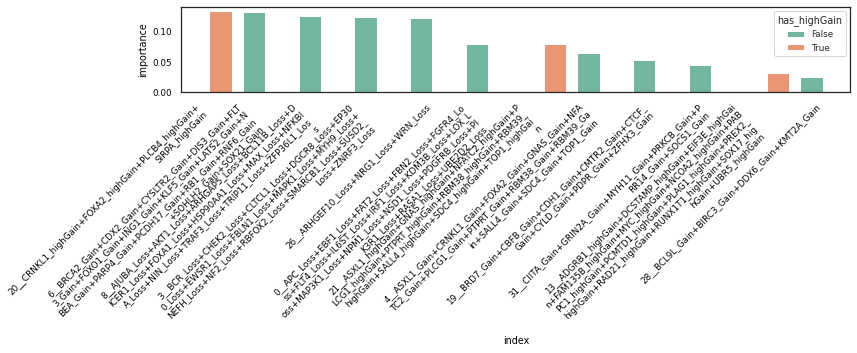

In [147]:
# plot feature importance for selected cluster features
chi2_selected = agg_labels_full[grid.best_estimator_[-2].get_support()]
importance = pd.Series(grid.best_estimator_[-1].feature_importances_,
                        name='importance',
                        index=[str(n) for n in chi2_selected]).\
                            reset_index().sort_values('importance', ascending=False)
# label clusters containing high gain features
importance['has_highGain'] = importance['index'].str.contains('highGain')
fig,ax = plt.subplots(figsize=(12,5))
ax = sb.barplot(y="importance",
                    x="index", 
                    hue='has_highGain',
                    palette='Set2', 
                    data=importance,
                    ax=ax)
# split long labels onto multiple lines
max_chars = 50
new_labels = ['\n'.join(label._text[i:i + max_chars ] 
                        for i in range(0, len(label._text), max_chars ))
              for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

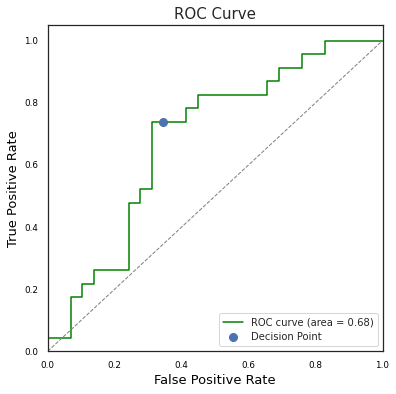

In [116]:
# plot ROC
fp_rates, tp_rates, _ = roc_curve(y_test,y_test_predict_proba[:,1])
roc_auc = auc(fp_rates, tp_rates)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fp_rates, tp_rates, color='green',
            lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')

#plot decision point:
cm =  confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = [i for i in cm.ravel()]
plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title('ROC Curve', size=15)
plt.legend(loc="lower right", prop={'size': 10})
plt.subplots_adjust(wspace=.3)

# Conclusions and Next Steps
Summarize findings here

There's a minor improvement in single-omic predictive performance (~.01 ROC AUC) by using highGain features.